# Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os

train_data_dir = '/content/drive/MyDrive/BT4221 Project/Processing   Model /Data/train'
test_data_dir = '/content/drive/MyDrive/BT4221 Project/Processing   Model /Data/test'


Pneumona_img = os.listdir(train_data_dir + "/PNEUMONIA")
Normal_img = os.listdir(train_data_dir + "/NORMAL")
COVID19_img = os.listdir(train_data_dir + "/COVID19")

In [3]:
os.chdir('/content/drive/MyDrive/BT4221 Project/Processing   Model /Data/')

# Import Packages

In [4]:
import pandas as pd         
import numpy as np         
import os                  
from random import shuffle
import tensorflow as tf 
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Flatten, Softmax, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
import seaborn as sns
import keras
from keras import layers
from numpy.random import seed
import tensorflow

from tensorflow.keras import Model
from tensorflow.keras.layers import LeakyReLU #, Dense, Dropout, Flatten
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.applications.resnet import preprocess_input



# Functions

In [5]:
# Set seed
seed(1)
tensorflow.random.set_seed(2)

In [6]:
# Print Graphs (training vs testing)
def plotting(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.ylabel(string)
    plt.xlabel("Epochs")
    plt.legend([string, "val_"+string])
    plt.show()


In [7]:
train_datagen = ImageDataGenerator(
      rescale = 1./255)

train_generator =train_datagen.flow_from_directory(
     train_data_dir,
     batch_size= 8,
     seed=42,
     shuffle=True, 
     target_size = (224,224))

test_datagen = ImageDataGenerator(
    rescale = 1./255)

test_generator =test_datagen.flow_from_directory(
     test_data_dir,
     batch_size= 1,
     seed=42,
     shuffle=False, 
     target_size = (224,224)) 

Found 6033 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


In [8]:
# To Tackle Issue of Imbalanced Dataset during Model Fitting
pneumonia_cases = len(Pneumona_img)
normal_cases = len(Normal_img)
covid_cases = len(COVID19_img)

pneumonia_weight = pneumonia_cases / (pneumonia_cases + normal_cases + covid_cases)
normal_weight = normal_cases / (pneumonia_cases + normal_cases + covid_cases)
covid_weight = covid_cases / (pneumonia_cases + normal_cases + covid_cases)

class_weight = {0: covid_weight, 1: normal_weight,
                2: pneumonia_weight}

print(f"Weight for class 0: {covid_weight:.2f}")
print(f"Weight for class 1: {normal_weight:.2f}")
print(f"Weight for class 2: {pneumonia_weight:.2f}")

Weight for class 0: 0.22
Weight for class 1: 0.21
Weight for class 2: 0.57


In [9]:
model = ResNet50(input_shape=(224,224,3),
                             include_top=False,
                             weights='imagenet')
for layer in model.layers:
    layer.trainable = False
model.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________

# 0 Dropout Layer (base)
## test 90.45%, train 89.13%)

In [ ]:
x = Flatten()(model.output)
# x = tf.keras.layers.Dropout(rate=0.25)(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
output = Dense(3, activation='softmax')(x)
model1 = Model(inputs=model.input, outputs=output)

In [ ]:
model1.compile(optimizer ="adam", 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=8)
mc = ModelCheckpoint("resnet_dropout_model1.h5", monitor='val_loss',save_best_only=True, mode='min',verbose=1)

In [ ]:
history1 = model1.fit(train_generator,
                      validation_data=test_generator,
                      callbacks=[mc,es],
                      class_weight = class_weight,
                      epochs=20,
                      verbose=1)

Epoch 1/20
755/755 [==============================] - 1440s 2s/step - loss: 0.3538 - accuracy: 0.6831 - val_loss: 0.4273 - val_accuracy: 0.7927

Epoch 00001: val_loss improved from inf to 0.42730, saving model to resnet_dropout_model1.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
755/755 [==============================] - 234s 310ms/step - loss: 0.1308 - accuracy: 0.8132 - val_loss: 0.4181 - val_accuracy: 0.8470

Epoch 00002: val_loss improved from 0.42730 to 0.41815, saving model to resnet_dropout_model1.h5
Epoch 3/20
755/755 [==============================] - 237s 314ms/step - loss: 0.1159 - accuracy: 0.8394 - val_loss: 0.4059 - val_accuracy: 0.8238

Epoch 00003: val_loss improved from 0.41815 to 0.40590, saving model to resnet_dropout_model1.h5
Epoch 4/20
755/755 [==============================] - 230s 305ms/step - loss: 0.1149 - accuracy: 0.8463 - val_loss: 0.6692 - val_accuracy: 0.7283

Epoch 00004: val_loss did not improve from 0.40590
Epoch 5/20
755/755 [==============================] - 222s 294ms/step - loss: 0.1293 - accuracy: 0.8231 - val_loss: 0.6571 - val_accuracy: 0.7469

Epoch 00005: val_loss did not improve from 0.40590
Epoch 6/20
755/755 [==============================] - 227s 300ms/step - loss: 0.1080 - accuracy: 0.8480 - val_loss: 

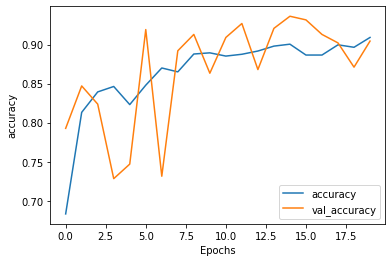

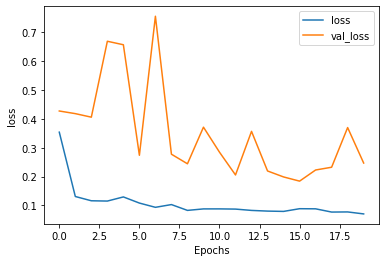

In [ ]:
# Print Graphs (training vs testing)
def plotting(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.ylabel(string)
    plt.xlabel("Epochs")
    plt.legend([string, "val_"+string])
    plt.show()

plotting(history1, "accuracy")
plotting(history1, "loss")

In [ ]:
# Get Accuracy Rate of Model (training and testing)
evaluation = model1.evaluate(test_generator)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model1.evaluate(train_generator)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

1288/1288 [==============================] - 54s 42ms/step - loss: 0.2468 - accuracy: 0.9045
Test Accuracy: 90.45%
755/755 [==============================] - 184s 243ms/step - loss: 0.2794 - accuracy: 0.8913
Train Accuracy: 89.13%


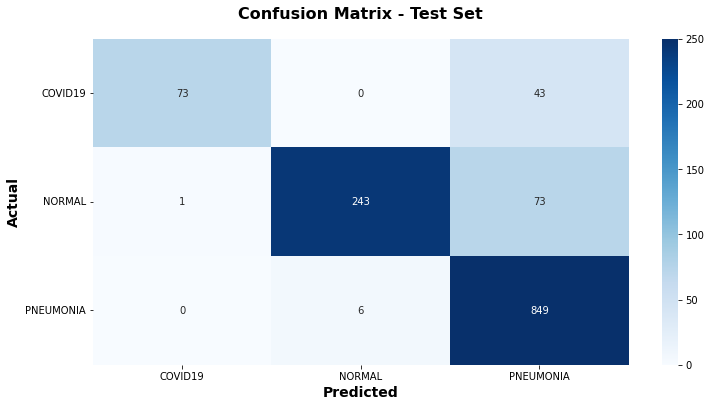

In [ ]:
# Print Confusion Matrix

classes = ['COVID19', 'NORMAL', 'PNEUMONIA']

pred_class = model1.predict(test_generator)
predictions = np.array(list(map(lambda x: np.argmax(x), pred_class)))

y_true= test_generator.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

# 1 Dropout Layer (compare with vgg)
## test 66.38%, train 56.66%

In [ ]:
x =  MaxPooling2D(pool_size = (2, 2), 
                               strides = 1, padding = 'valid')(model.output)

x = Flatten()(x)

x = Dense(256, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)

output = Dense(3, activation='softmax')(x)
model2 = Model(inputs=model.input, outputs=output)

In [ ]:
model2.compile(optimizer ="adam", 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=8)
mc = ModelCheckpoint("resnet_dropout_model2.h5", monitor='val_loss',save_best_only=True, mode='min',verbose=1)

In [ ]:
history2 = model2.fit(train_generator,
                      validation_data=test_generator,
                      callbacks=[mc],
                      class_weight = class_weight,
                      epochs=20,
                      verbose=1)

Epoch 1/20
755/755 [==============================] - 245s 320ms/step - loss: 0.4654 - accuracy: 0.5607 - val_loss: 0.9133 - val_accuracy: 0.6638

Epoch 00001: val_loss improved from inf to 0.91335, saving model to resnet_dropout_model2.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
755/755 [==============================] - 247s 326ms/step - loss: 0.2897 - accuracy: 0.5667 - val_loss: 0.9215 - val_accuracy: 0.6638

Epoch 00002: val_loss did not improve from 0.91335
Epoch 3/20
755/755 [==============================] - 244s 323ms/step - loss: 0.2875 - accuracy: 0.5666 - val_loss: 0.9149 - val_accuracy: 0.6638

Epoch 00003: val_loss did not improve from 0.91335
Epoch 4/20
755/755 [==============================] - 242s 321ms/step - loss: 0.2878 - accuracy: 0.5666 - val_loss: 0.9057 - val_accuracy: 0.6638

Epoch 00004: val_loss improved from 0.91335 to 0.90568, saving model to resnet_dropout_model2.h5
Epoch 5/20
755/755 [==============================] - 245s 325ms/step - loss: 0.2876 - accuracy: 0.5666 - val_loss: 0.9187 - val_accuracy: 0.6638

Epoch 00005: val_loss did not improve from 0.90568
Epoch 6/20
755/755 [==============================] - 241s 319ms/step - loss: 0.2875 - accuracy: 0.5666 - val_loss: 0.8933 - val_accuracy: 0.6638

Epoch 00006: va

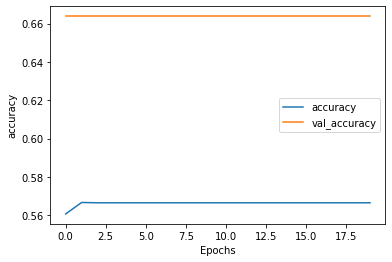

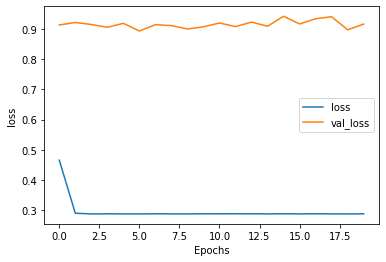

In [ ]:
plotting(history2, "accuracy")
plotting(history2, "loss")

In [ ]:
# Get Accuracy Rate of Model (training and testing)
evaluation = model2.evaluate(test_generator)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model2.evaluate(train_generator)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

1288/1288 [==============================] - 57s 44ms/step - loss: 0.9162 - accuracy: 0.6638
Test Accuracy: 66.38%
755/755 [==============================] - 184s 244ms/step - loss: 1.1029 - accuracy: 0.5666
Train Accuracy: 56.66%


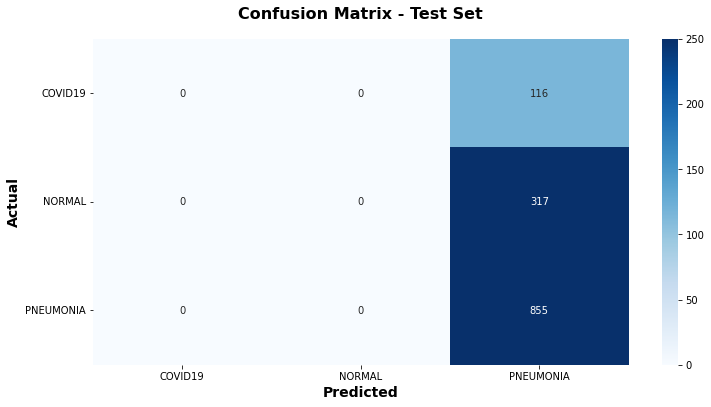

In [ ]:
# Print Confusion Matrix

classes = ['COVID19', 'NORMAL', 'PNEUMONIA']

pred_class = model2.predict(test_generator)
predictions = np.array(list(map(lambda x: np.argmax(x), pred_class)))

y_true= test_generator.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

didnt run those below!!

(224, 224, 3)

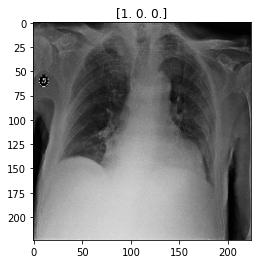

In [ ]:
test_img = test_generator.__getitem__(1)
preview_imgs, preview_labels = test_img
plt.title(str(preview_labels[0]))
plt.imshow(preview_imgs[0])

img = preview_imgs[0]
img.shape

In [ ]:
os.chdir('/content/drive/MyDrive/BT4221 Project/Processing   Model /Data/vizgradcam')

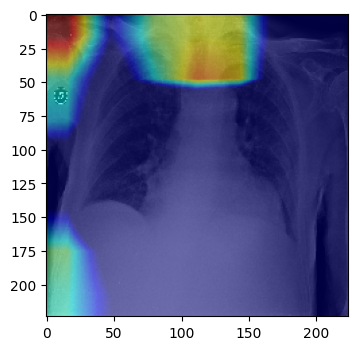

In [ ]:
from gradcam import VizGradCAM

VizGradCAM(
    model2,   #load model   (this is your model)
    img
)

/content/drive/.shortcut-targets-by-id/1tBdSji21KgPglmR793LZtaDQOEIckCP4/BT4221 Project/Processing   Model /Data/vizgradcam/gradcam.py:77: RuntimeWarning: invalid value encountered in true_divide
  activation_map.max() - activation_map.min()


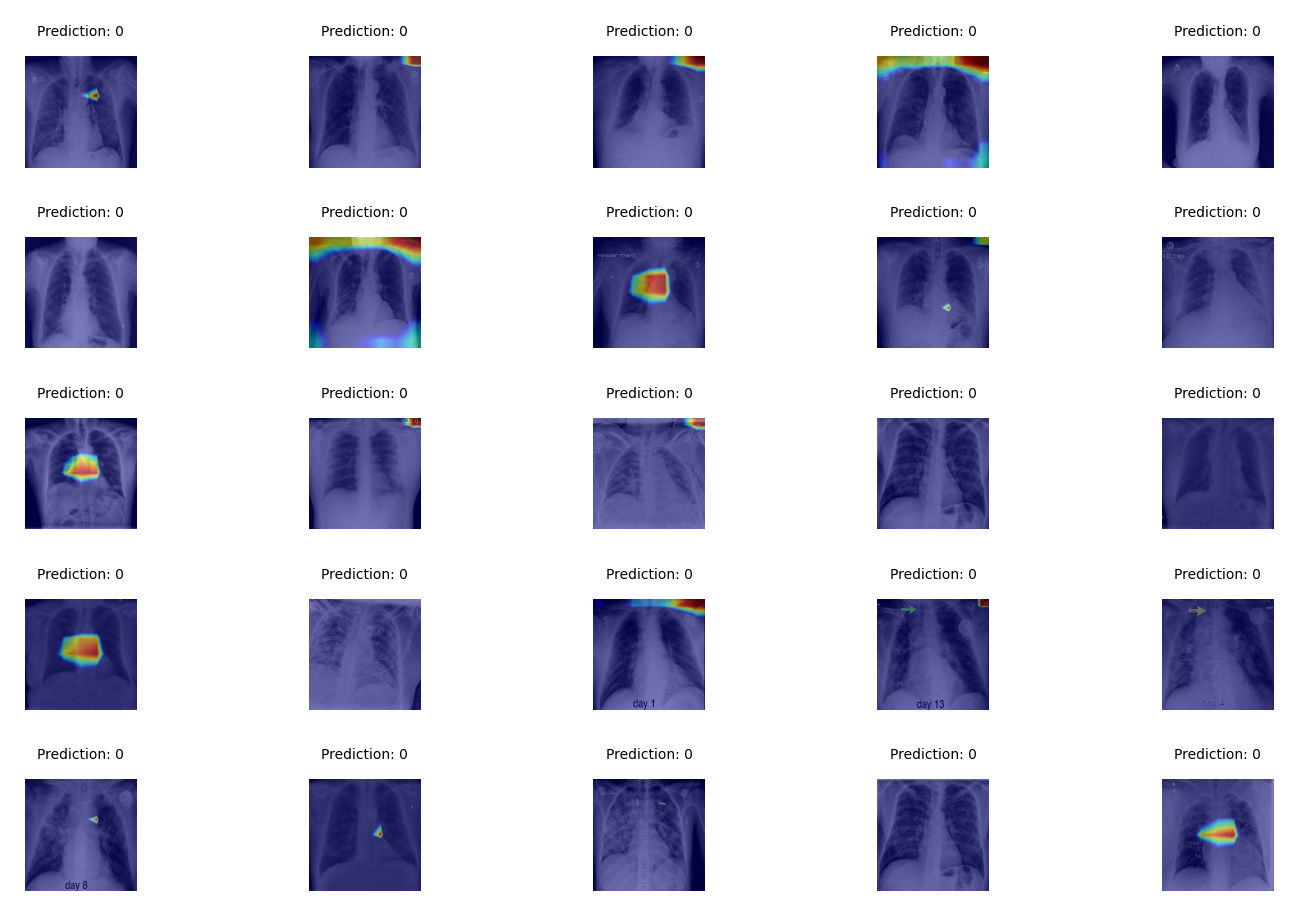

In [ ]:
for i in range(25):
  # define subplot
  plt.rcParams["figure.dpi"] = 250
  plt.subplot(5,5, i+1)
  plt.tight_layout()
  img = test_generator.__getitem__(i+25)
  preview_img, preview_labels = img
  pred = model2.predict(preview_img[0].reshape(1, 224, 224, 3))
  plt.title("Prediction: " + str(pred.argmax()),fontsize = 4)
  plt.axis('off')
  VizGradCAM(model2, preview_img[0])

# Constant Number of Neurons (base to compare with vgg)
## test 80.59%, train 83.77%

In [12]:
x =  MaxPooling2D(pool_size = (2, 2), 
                               strides = 1, padding = 'valid')(model.output)

x = Flatten()(x)

x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)

output = Dense(3, activation='softmax')(x)
model3 = Model(inputs=model.input, outputs=output)

In [13]:
model3.compile(optimizer ="adam", 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [14]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=8)
mc = ModelCheckpoint("resnet_dropout_model3.h5", monitor='val_loss',save_best_only=True, mode='min',verbose=1)

In [15]:
history3 = model3.fit(train_generator,
                      validation_data=test_generator,
                      callbacks=[mc],
                      class_weight = class_weight,
                      epochs=25,
                      verbose=1)

Epoch 1/25
755/755 [==============================] - 1561s 2s/step - loss: 0.3740 - accuracy: 0.6383 - val_loss: 1.0814 - val_accuracy: 0.6638

Epoch 00001: val_loss improved from inf to 1.08142, saving model to resnet_dropout_model3.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/25
755/755 [==============================] - 237s 314ms/step - loss: 0.2386 - accuracy: 0.6378 - val_loss: 0.6505 - val_accuracy: 0.7081

Epoch 00002: val_loss improved from 1.08142 to 0.65048, saving model to resnet_dropout_model3.h5
Epoch 3/25
755/755 [==============================] - 239s 317ms/step - loss: 0.1925 - accuracy: 0.7197 - val_loss: 0.8545 - val_accuracy: 0.5730

Epoch 00003: val_loss did not improve from 0.65048
Epoch 4/25
755/755 [==============================] - 237s 315ms/step - loss: 0.1815 - accuracy: 0.7277 - val_loss: 0.5077 - val_accuracy: 0.7888

Epoch 00004: val_loss improved from 0.65048 to 0.50773, saving model to resnet_dropout_model3.h5
Epoch 5/25
755/755 [==============================] - 241s 320ms/step - loss: 0.1639 - accuracy: 0.7598 - val_loss: 0.5446 - val_accuracy: 0.7539

Epoch 00005: val_loss did not improve from 0.50773
Epoch 6/25
755/755 [==============================] - 234s 309ms/step - loss: 0.1558 - accuracy: 0.7678 - val_loss: 

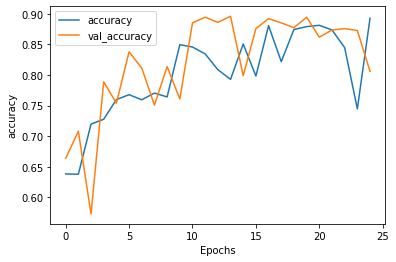

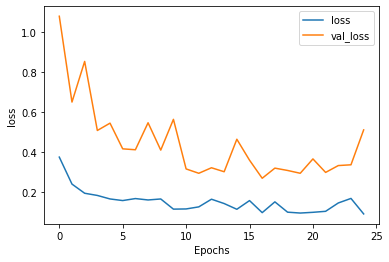

In [16]:
plotting(history3, "accuracy")
plotting(history3, "loss")

In [17]:
# Get Accuracy Rate of Model (training and testing)
evaluation = model3.evaluate(test_generator)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model3.evaluate(train_generator)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

1288/1288 [==============================] - 51s 40ms/step - loss: 0.5107 - accuracy: 0.8059
Test Accuracy: 80.59%
755/755 [==============================] - 174s 230ms/step - loss: 0.4619 - accuracy: 0.8377
Train Accuracy: 83.77%


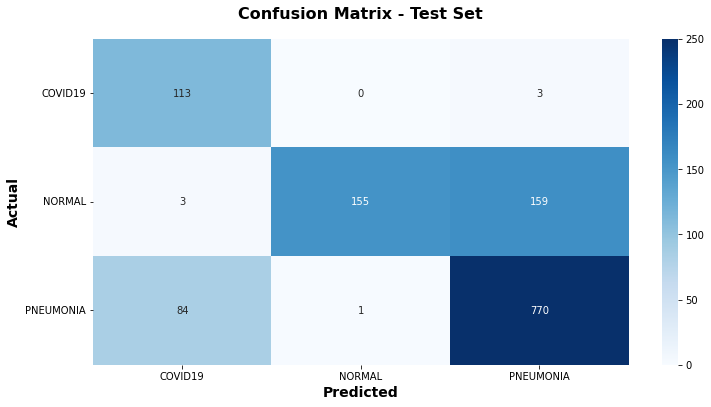

In [18]:
# Print Confusion Matrix

classes = ['COVID19', 'NORMAL', 'PNEUMONIA']

pred_class = model3.predict(test_generator)
predictions = np.array(list(map(lambda x: np.argmax(x), pred_class)))

y_true= test_generator.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

# IGNORE Constant Number of Neurons (256 in each layer)
## test 87.81%, train 87.27%

In [ ]:
x = Flatten()(model.output)

x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)

output = Dense(3, activation='softmax')(x)
model3 = Model(inputs=model.input, outputs=output)

In [ ]:
model3.compile(optimizer ="adam", 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=8)
mc = ModelCheckpoint("resnet_dropout_model3.h5", monitor='val_loss',save_best_only=True, mode='min',verbose=1)

In [ ]:
history3 = model3.fit(train_generator,
                      validation_data=test_generator,
                      callbacks=[mc],
                      class_weight = class_weight,
                      epochs=20,
                      verbose=1)

Epoch 1/20
755/755 [==============================] - 2960s 4s/step - loss: 0.2869 - accuracy: 0.6532 - val_loss: 0.4179 - val_accuracy: 0.8238

Epoch 00001: val_loss improved from inf to 0.41793, saving model to resnet_dropout_model3.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
755/755 [==============================] - 236s 313ms/step - loss: 0.1620 - accuracy: 0.7386 - val_loss: 0.5038 - val_accuracy: 0.7314

Epoch 00002: val_loss did not improve from 0.41793
Epoch 3/20
755/755 [==============================] - 236s 312ms/step - loss: 0.1321 - accuracy: 0.7920 - val_loss: 0.3542 - val_accuracy: 0.8711

Epoch 00003: val_loss improved from 0.41793 to 0.35417, saving model to resnet_dropout_model3.h5
Epoch 4/20
755/755 [==============================] - 235s 311ms/step - loss: 0.1263 - accuracy: 0.8216 - val_loss: 0.7639 - val_accuracy: 0.6172

Epoch 00004: val_loss did not improve from 0.35417
Epoch 5/20
755/755 [==============================] - 233s 308ms/step - loss: 0.1058 - accuracy: 0.8540 - val_loss: 0.4203 - val_accuracy: 0.8183

Epoch 00005: val_loss did not improve from 0.35417
Epoch 6/20
755/755 [==============================] - 235s 312ms/step - loss: 0.0974 - accuracy: 0.8719 - val_loss: 0.2810 - val_accuracy: 0.9030

Epoch 00006: va

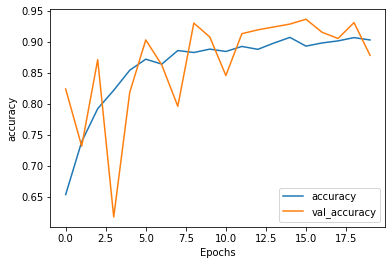

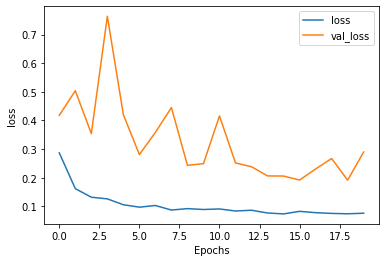

In [ ]:
# Print Graphs (training vs testing)
def plotting(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.ylabel(string)
    plt.xlabel("Epochs")
    plt.legend([string, "val_"+string])
    plt.show()

plotting(history3, "accuracy")
plotting(history3, "loss")

In [ ]:
# Get Accuracy Rate of Model (training and testing)
evaluation = model3.evaluate(test_generator)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model3.evaluate(train_generator)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

1288/1288 [==============================] - 57s 44ms/step - loss: 0.2898 - accuracy: 0.8781
Test Accuracy: 87.81%
755/755 [==============================] - 189s 251ms/step - loss: 0.2950 - accuracy: 0.8727
Train Accuracy: 87.27%


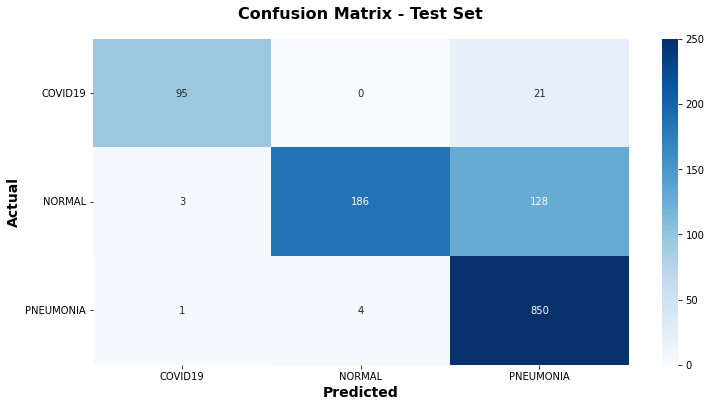

In [ ]:
# Print Confusion Matrix

classes = ['COVID19', 'NORMAL', 'PNEUMONIA']

pred_class = model3.predict(test_generator)
predictions = np.array(list(map(lambda x: np.argmax(x), pred_class)))

y_true= test_generator.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

# 2 Dropout Layer (66.38%)

In [ ]:
x = Flatten()(model.output)

x = Dropout(rate=0.25)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(rate=0.25)(x)
x = Dense(128, activation='relu')(x)

output = Dense(3, activation='softmax')(x)
model4 = Model(inputs=model.input, outputs=output)

In [ ]:
model4.compile(optimizer ="adam", 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=8)
mc = ModelCheckpoint("resnet_model4.h5", monitor='val_loss',save_best_only=True, mode='min',verbose=1)

In [ ]:
history4 = model4.fit(train_generator,
                      validation_data=test_generator,
                      callbacks=[mc,es],
                      class_weight = class_weight,
                      epochs=20,
                      verbose=1)

Epoch 1/20
755/755 [==============================] - 2854s 4s/step - loss: 0.5060 - accuracy: 0.5535 - val_loss: 0.8642 - val_accuracy: 0.6638

Epoch 00001: val_loss improved from inf to 0.86422, saving model to resnet_model4.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
755/755 [==============================] - 1467s 2s/step - loss: 0.2884 - accuracy: 0.5666 - val_loss: 0.9151 - val_accuracy: 0.6638

Epoch 00002: val_loss did not improve from 0.86422
Epoch 3/20
755/755 [==============================] - 1475s 2s/step - loss: 0.2876 - accuracy: 0.5666 - val_loss: 0.9203 - val_accuracy: 0.6638

Epoch 00003: val_loss did not improve from 0.86422
Epoch 4/20
755/755 [==============================] - 1485s 2s/step - loss: 0.2873 - accuracy: 0.5666 - val_loss: 0.9255 - val_accuracy: 0.6638

Epoch 00004: val_loss did not improve from 0.86422
Epoch 5/20
755/755 [==============================] - 1477s 2s/step - loss: 0.2874 - accuracy: 0.5666 - val_loss: 0.9181 - val_accuracy: 0.6638

Epoch 00005: val_loss did not improve from 0.86422
Epoch 6/20
755/755 [==============================] - 1488s 2s/step - loss: 0.2876 - accuracy: 0.5666 - val_loss: 0.9039 - val_accuracy: 0.6638

Epoch 00006: val_loss did not improve from 0.86422
Epoch 7/20
755/755 [

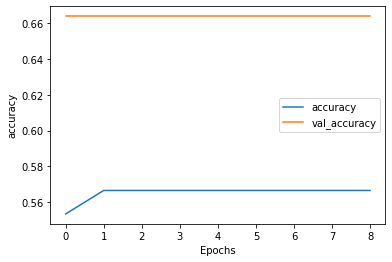

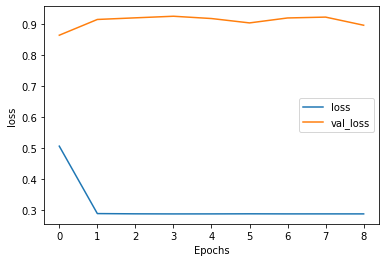

In [ ]:
# Print Graphs (training vs testing)
def plotting(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.ylabel(string)
    plt.xlabel("Epochs")
    plt.legend([string, "val_"+string])
    plt.show()

plotting(history4, "accuracy")
plotting(history4, "loss")

In [ ]:
# Get Accuracy Rate of Model (training and testing)
evaluation = model4.evaluate(test_generator)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model4.evaluate(train_generator)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

1288/1288 [==============================] - 297s 231ms/step - loss: 0.8964 - accuracy: 0.6638
Test Accuracy: 66.38%
755/755 [==============================] - 1122s 1s/step - loss: 1.0720 - accuracy: 0.5666
Train Accuracy: 56.66%


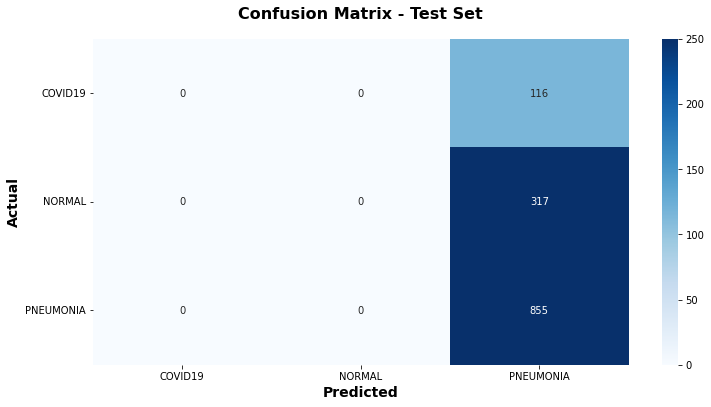

In [ ]:
# Print Confusion Matrix

classes = ['COVID19', 'NORMAL', 'PNEUMONIA']

pred_class = model4.predict(test_generator)
predictions = np.array(list(map(lambda x: np.argmax(x), pred_class)))

y_true= test_generator.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);